<a href="https://colab.research.google.com/github/brendan123/Semantic-Segmentation/blob/milestone-4/Milestone_4_Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone --branch milestone-4 https://github.com/brendan123/Semantic-Segmentation.git
! mv Semantic-Segmentation/hpo_best_model.hdf5 ./
! rm -rf Semantic-Segmentation

Cloning into 'Semantic-Segmentation'...
remote: Enumerating objects: 205, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 205 (delta 19), reused 6 (delta 6), pack-reused 178
Receiving objects: 100% (205/205), 56.67 MiB | 20.29 MiB/s, done.
Resolving deltas: 100% (66/66), done.


In [2]:
! pip install nni
! pip install patchify
! pip install segmentation-models
! pip install -q tensorflow-model-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from keras.models import Model
from keras import backend as K
import segmentation_models as sm

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss) 

Segmentation Models: using `keras` framework.


In [4]:
from keras.models import load_model
model = load_model("hpo_best_model.hdf5",
                   custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [5]:
import tensorflow as tf
from nni.compression.tensorflow import Pruner

class OneshotPruner(Pruner):
    def __init__(self, model, config_list, masker_class, **algo_kwargs):
        super().__init__(model, config_list)
        self.set_wrappers_attribute('calculated', False)
        self.masker = masker_class(model, self, **algo_kwargs)

    def validate_config(self, model, config_list):
        pass  # TODO

    def calc_masks(self, wrapper, wrapper_idx=None):
        if wrapper.calculated:
            return None
        sparsity = wrapper.config['sparsity']
        masks = self.masker.calc_masks(sparsity, wrapper, wrapper_idx)
        if masks is not None:
            wrapper.calculated = True
        return masks


class LevelPruner(OneshotPruner):
    def __init__(self, model, config_list):
        super().__init__(model, config_list, LevelPrunerMasker)


class SlimPruner(OneshotPruner):
    def __init__(self, model, config_list):
        super().__init__(model, config_list, SlimPrunerMasker)


class WeightMasker:
    def __init__(self, model, pruner, **kwargs):
        self.model = model
        self.pruner = pruner

    def calc_masks(self, sparsity, wrapper, wrapper_idx=None):
        raise NotImplementedError()


class LevelPrunerMasker(WeightMasker):
    def calc_masks(self, sparsity, wrapper, wrapper_idx=None):
        masks = {}
        for weight_variable in wrapper.layer.weights:
            if 'bias' in weight_variable.name:
                continue

            num_prune = int(tf.size(weight_variable).numpy() * sparsity)
            if num_prune == 0:
                continue

            weight = weight_variable.read_value()
            if wrapper.masks.get(weight_variable.name) is not None:
                weight = tf.math.multiply(weight, wrapper.masks[weight_variable.name])

            w_abs = tf.math.abs(weight)
            k = tf.size(weight) - num_prune
            topk = tf.math.top_k(tf.reshape(w_abs, [-1]), k).values
            if tf.size(topk) == 0:
                mask = tf.zeros_like(weight)
            else:
                mask = tf.math.greater_equal(w_abs, topk[-1])
            masks[weight_variable.name] = tf.cast(mask, weight.dtype)
        return masks

class SlimPrunerMasker(WeightMasker):
    def __init__(self, model, pruner, **kwargs):
        super().__init__(model, pruner)
        weight_list = []
        for wrapper in pruner.wrappers:
            weights = [w for w in wrapper.layer.weights if '/gamma:' in w.name]
            assert len(weights) == 1, f'Bad weights: {[w.name for w in wrapper.layer.weights]}'
            weight_list.append(tf.math.abs(weights[0].read_value()))
        all_bn_weights = tf.concat(weight_list, 0)
        k = int(all_bn_weights.shape[0] * pruner.wrappers[0].config['sparsity'])
        top_k = -tf.math.top_k(-tf.reshape(all_bn_weights, [-1]), k).values
        self.global_threshold = top_k.numpy()[-1]

    def calc_masks(self, sparsity, wrapper, wrapper_idx=None):
        assert isinstance(wrapper.layer, tf.keras.layers.BatchNormalization), \
                'SlimPruner only supports 2D batch normalization layer pruning'

        weight = None
        weight_name = None
        bias_name = None

        for variable in wrapper.layer.weights:
            if '/gamma:' in variable.name:
                weight = variable.read_value()
                weight_name = variable.name
            elif '/beta:' in variable.name:
                bias_name = variable.name

        assert weight is not None
        if wrapper.masks.get(weight_name) is not None:
            weight *= wrapper.masks[weight_name]

        mask = tf.cast(tf.math.abs(weight) > self.global_threshold, weight.dtype)

        masks = {weight_name: mask}
        if bias_name:
            masks[bias_name] = mask
        return masks

In [6]:
import tensorflow as tf
config_list = [{ 'sparsity': 0.8, 'op_types': ['default'] }]
pruner = LevelPruner(model, config_list)
new_model = pruner.compress()

[2022-12-04 01:56:32] Layer detected to compress: conv2d


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d


[2022-12-04 01:56:32] Layer detected to compress: conv2d_1


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_1


[2022-12-04 01:56:32] Layer detected to compress: conv2d_2


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_2


[2022-12-04 01:56:32] Layer detected to compress: conv2d_3


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_3


[2022-12-04 01:56:32] Layer detected to compress: conv2d_4


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_4


[2022-12-04 01:56:32] Layer detected to compress: conv2d_5


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_5


[2022-12-04 01:56:32] Layer detected to compress: conv2d_6


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_6


[2022-12-04 01:56:32] Layer detected to compress: conv2d_7


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_7


[2022-12-04 01:56:32] Layer detected to compress: conv2d_8


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_8


[2022-12-04 01:56:32] Layer detected to compress: conv2d_9


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_9


[2022-12-04 01:56:32] Layer detected to compress: conv2d_transpose


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_transpose


[2022-12-04 01:56:32] Layer detected to compress: conv2d_10


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_10


[2022-12-04 01:56:32] Layer detected to compress: conv2d_11


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_11


[2022-12-04 01:56:32] Layer detected to compress: conv2d_transpose_1


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_transpose_1


[2022-12-04 01:56:32] Layer detected to compress: conv2d_12


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_12


[2022-12-04 01:56:32] Layer detected to compress: conv2d_13


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_13


[2022-12-04 01:56:32] Layer detected to compress: conv2d_transpose_2


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_transpose_2


[2022-12-04 01:56:32] Layer detected to compress: conv2d_14


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_14


[2022-12-04 01:56:32] Layer detected to compress: conv2d_15


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_15


[2022-12-04 01:56:32] Layer detected to compress: conv2d_transpose_3


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_transpose_3


[2022-12-04 01:56:32] Layer detected to compress: conv2d_16


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_16


[2022-12-04 01:56:32] Layer detected to compress: conv2d_17


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_17


[2022-12-04 01:56:32] Layer detected to compress: conv2d_18


INFO:nni.compression.tensorflow.compressor:Layer detected to compress: conv2d_18


At this point we discovered that NNI has no support for the actual speedup process of a Tensorflow model. It generated masks only. So we switched to a Tensorflow-specific method.

In [7]:
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 700 ~/.kaggle/kaggle.json
! kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery
! unzip semantic-segmentation-of-aerial-imagery.zip
! rm semantic-segmentation-of-aerial-imagery.zip
! rm kaggle.json # Delete kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
 98% 29.0M/29.6M [00:01<00:00, 36.3MB/s]
100% 29.6M/29.6M [00:01<00:00, 23.4MB/s]
Archive:  semantic-segmentation-of-aerial-imagery.zip
replace Semantic segmentation dataset/Tile 1/images/image_part_001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_001.jpg  
replace Semantic segmentation dataset/Tile 1/images/image_part_002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_002.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_003.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_004.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_005.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_006.jpg  
  inflating: Semantic segmentation dataset/Tile 1/images/image_part_007.jpg  


['image_part_001.jpg', 'image_part_002.jpg', 'image_part_003.jpg', 'image_part_004.jpg', 'image_part_005.jpg', 'image_part_006.jpg', 'image_part_007.jpg', 'image_part_008.jpg', 'image_part_009.jpg']
Now patchifying image: Semantic segmentation dataset/Tile 7/images/image_part_001.jpg
Now patchifying image: Semantic segmentation dataset/Tile 7/images/image_part_002.jpg
Now patchifying image: Semantic segmentation dataset/Tile 7/images/image_part_003.jpg
Now patchifying image: Semantic segmentation dataset/Tile 7/images/image_part_004.jpg
Now patchifying image: Semantic segmentation dataset/Tile 7/images/image_part_005.jpg
Now patchifying image: Semantic segmentation dataset/Tile 7/images/image_part_006.jpg
Now patchifying image: Semantic segmentation dataset/Tile 7/images/image_part_007.jpg
Now patchifying image: Semantic segmentation dataset/Tile 7/images/image_part_008.jpg
Now patchifying image: Semantic segmentation dataset/Tile 7/images/image_part_009.jpg
['image_part_001.jpg', 'ima

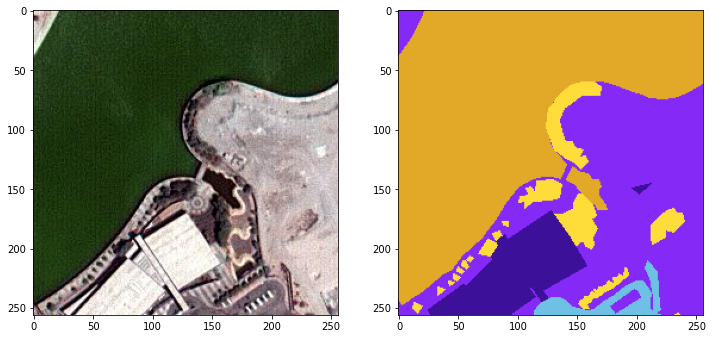

60
Unique labels in label dataset are:  [0 1 2 3 4 5]


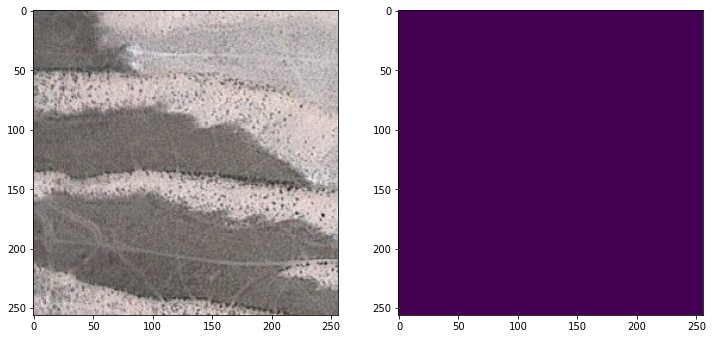

In [8]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU, Recall, Precision

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

root_directory = 'Semantic segmentation dataset/'

patch_size = 256

#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = os.listdir(path)  #List of all image names in this subdirectory
        images.sort()
        print(images)
        for i, image_name in enumerate(images):  
            if image_name.endswith(".jpg"):   #Only read jpg images...
               
                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)             
       
                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        
                        single_patch_img = patches_img[i,j,:,:]
                        
                        #Use minmaxscaler instead of just dividing by 255. 
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. 
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
                        image_dataset.append(single_patch_img)
                
  
                
  
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []  
for path, subdirs, files in os.walk(root_directory):
    #print(path)  
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = os.listdir(path)  #List of all image names in this subdirectory
        masks.sort()
        print(masks)
        for i, mask_name in enumerate(masks):  
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
               
                mask = cv2.imread(path+"/"+mask_name, 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)             
       
                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
        
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        
                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.                               
                        mask_dataset.append(single_patch_mask) 
 
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

#Convert HEX to RGB array
# Try the following to understand how python handles hex values...
a=int('3C', 16)  #3C with base 16. Should return 60. 
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#') 
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#') 
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#') 
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#') 
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)
 

print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [32]:
from keras.models import load_model
model = load_model("hpo_best_model.hdf5",
                   custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [34]:
import tensorflow_model_optimization as tfmot
from tensorflow.keras.metrics import MeanIoU, Recall, Precision
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Define model for pruning.
epochs = 500
end_step = np.ceil(X_train.shape[0] / 24).astype(np.int32) * epochs
print(end_step)
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.25,
                                                               final_sparsity=0.75,
                                                               begin_step=0,
                                                               end_step=end_step),
}

new_model = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
adam = tf.keras.optimizers.Adam(learning_rate=0.002)
metrics=['accuracy', jacard_coef, Precision(), Recall()]
new_model.compile(optimizer=adam,
                  loss=total_loss,
                  metrics=metrics)

new_model.summary()

22000
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 prune_low_magnitude_conv2d (Pr  (None, 256, 256, 16  882        ['input_1[0][0]']                
 uneLowMagnitude)               )                                                                 
                                                                                                  
 prune_low_magnitude_dropout (P  (None, 256, 256, 16  1          ['prune_low_magnitude_conv2d[0][0
 runeLowMagnitude)              )                                ]']                    

In [35]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir="test"),
]

new_model.fit(X_train, y_train,
          batch_size=24, epochs=epochs, validation_data=(X_test, y_test),
          callbacks=callbacks)

Epoch 1/500
44/44 [==============================] - 25s 143ms/step - loss: 0.9079 - accuracy: 0.8459 - jacard_coef: 0.6837 - precision: 0.8591 - recall: 0.8345 - val_loss: 0.9099 - val_accuracy: 0.8542 - val_jacard_coef: 0.7012 - val_precision: 0.8653 - val_recall: 0.8444
Epoch 2/500
44/44 [==============================] - 4s 83ms/step - loss: 0.9066 - accuracy: 0.8451 - jacard_coef: 0.6847 - precision: 0.8587 - recall: 0.8337 - val_loss: 0.9202 - val_accuracy: 0.8233 - val_jacard_coef: 0.6523 - val_precision: 0.8381 - val_recall: 0.8104
Epoch 3/500
44/44 [==============================] - 4s 83ms/step - loss: 0.9100 - accuracy: 0.8413 - jacard_coef: 0.6769 - precision: 0.8568 - recall: 0.8281 - val_loss: 0.9097 - val_accuracy: 0.8549 - val_jacard_coef: 0.6974 - val_precision: 0.8669 - val_recall: 0.8443
Epoch 4/500
44/44 [==============================] - 4s 84ms/step - loss: 0.9052 - accuracy: 0.8518 - jacard_coef: 0.6926 - precision: 0.8646 - recall: 0.8408 - val_loss: 0.9058 - va

In [38]:
new_model.save("new_model.hdf5")

1/1 [==============================] - 0s 20ms/step


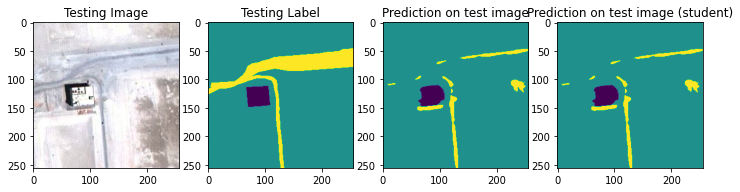

1/1 [==============================] - 0s 20ms/step


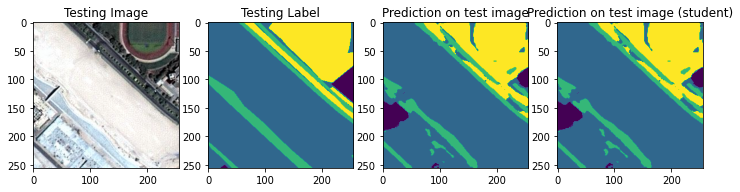

1/1 [==============================] - 0s 21ms/step


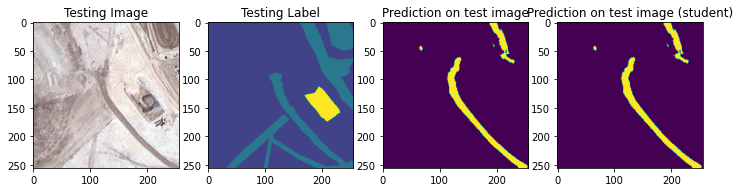

1/1 [==============================] - 0s 20ms/step


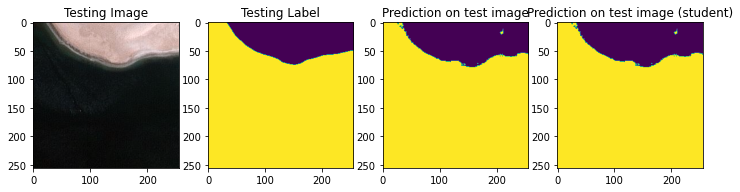

1/1 [==============================] - 0s 20ms/step


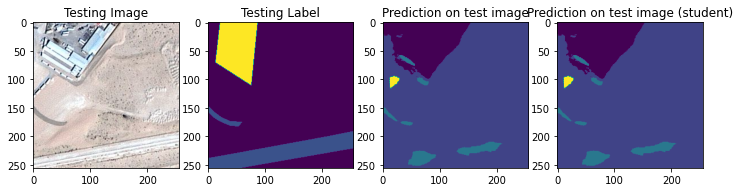

1/1 [==============================] - 0s 20ms/step


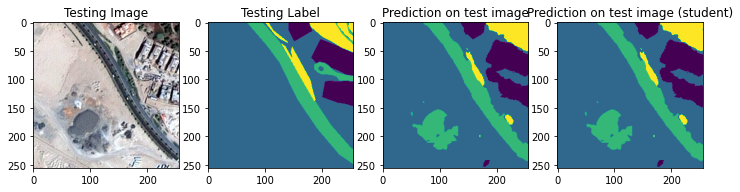

1/1 [==============================] - 0s 21ms/step


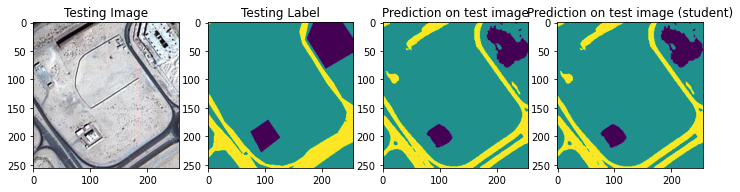

1/1 [==============================] - 0s 31ms/step


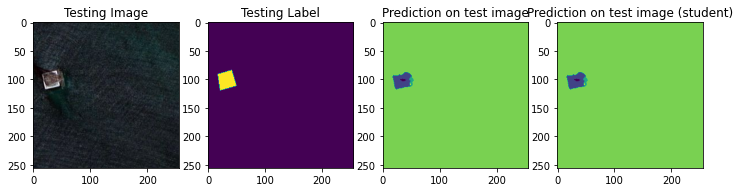

1/1 [==============================] - 0s 21ms/step


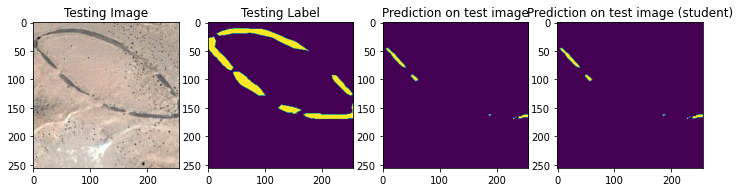

1/1 [==============================] - 0s 20ms/step


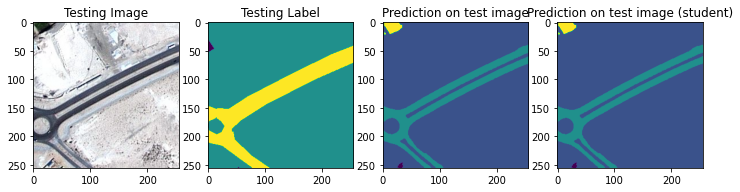

In [47]:
y_test_argmax=np.argmax(y_test, axis=3)
import random
import time

# generate 10 predictions
for i in range(10):
  test_img_number = random.randint(0, len(X_test)-1)
  test_img = X_test[test_img_number]
  ground_truth=y_test_argmax[test_img_number]
  #test_img_norm=test_img[:,:,0][:,:,None]
  test_img_input=np.expand_dims(test_img, 0)
  #%timeit prediction = (model.predict(test_img_input))
  #%timeit prediction_student = (new_model.predict(test_img_input))
  prediction = (model.predict(test_img_input))
  prediction_student = (new_model.predict(test_img_input))
  predicted_img=np.argmax(prediction, axis=3)[0,:,:]
  predicted_img_student=np.argmax(prediction_student, axis=3)[0,:,:]

  plt.figure(figsize=(12, 8))
  plt.subplot(241)
  plt.title('Testing Image')
  plt.imshow(test_img)
  plt.subplot(242)
  plt.title('Testing Label')
  plt.imshow(ground_truth)
  plt.subplot(243)
  plt.title('Prediction on test image')
  plt.imshow(predicted_img)
  plt.subplot(244)
  plt.title('Prediction on test image (student)')
  plt.imshow(predicted_img_student)
  plt.savefig("%s.jpg" % (i+1))
  plt.show()